In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *

## Step 3

In [3]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()

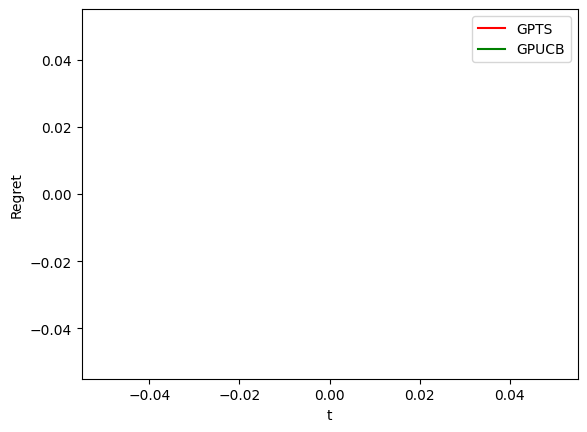

In [4]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean((opts-gpts_rewards_per_experiment.T).T, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean((opts-gpucb_rewards_per_experiment.T).T, axis = 0)), 'g')
plt.legend(["GPTS", "GPUCB"])
plt.show()

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets_step4(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts)

## Step 5

In [ ]:
gpucb_rewards_per_experiment, gpts_rewards_per_experiment, opts = simulate_step5()
plot_regrets_step5(gpts_rewards_per_experiment,gpucb_rewards_per_experiment,opts)

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets_step6(swucb_rewards_per_experiment,cducb_rewards_per_experiment, opts)